# Capstone Project: Stroke Risk Prediction - Exploratory Data Analysis #
This is a capstone project for Springboard's data science intensive track. The dataset used in this project is sourced from the data science competition sponsor by McKinsey analytics and held in a platform "Analytics Vidhya". 
The competition link can be found here [contest page] (https://datahack.analyticsvidhya.com/contest/mckinsey-analytics-online-hackathon/).

**Problem Statement:** a chain of hospitals in US collected anonymized pool of patients data for stroke classification. Stroke is one of critical disease which affects nearly 1 in 20 Americans and is a disease that affects arteries leading to and within the brain. A stroke occurs when a blood vessel that carries oxygen and nutrients to the brain is either blocked by a clot or ruptures. When that happens part of the brain cannot get the blood (and oxygen) it needs, so the brain cells in the affected region is dead. The clients captured several lifestyle, health monitoring measurements and demographic factors about their anonymized patients. These include features like age, gender, health monitoring measurements (i.e., glucose level, body mass index) and lifestyle factors (i.e., smoking status, occupation type etc.). 

**Stakeholders:**
Hospital cardiac unit managers, a group of clinicians, insurance companies and employers from patient population.

## Part A. Import Cleaned Dataset ##

In [1]:
# Import all libraries #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Authorization #
__author__ = "Taesun Yoo"
__email__ = "yoots1988@gmail.com"

In [2]:
# --- 2. Write Out List of Functions --- #
#################################
# Part 2 - Discover the Problem #
#################################
# Write a group of funtions:
def load_file(file):
    '''load input CSVs as a dataframe'''
    return pd.read_csv(file)

def clean_data(raw_df):
    '''remove rows that contain invalid data or duplicate IDs'''
    clean_df = raw_df.drop_duplicates(subset='id')
    return clean_df

def EDA_missing_data(cleaned_df):
    '''Performs missing % on each column '''
    missing_df = cleaned_df.isnull().sum()
    missing_df = pd.DataFrame(missing_df, columns=['count'])
    missing_df['pct'] = missing_df['count']/len(cleaned_df)
    missing_df = missing_df.sort_values(by='pct', ascending=False)
    return missing_df

def EDA_numerical_data(cleaned_df):
    '''Computes summary statistics on numerical data'''
    summary_df_num = cleaned_df.describe(include='all').T
    summary_df_num = pd.DataFrame(summary_df_num)[['count', 'std', 'min', 'mean', 'max', '25%', '50%', '75%']]
    return summary_df_num

def EDA_categorical_data(cleaned_df):
    '''Computes summary statitics on categorical data'''
    summary_df_cat = cleaned_df.describe(include=['O'])
    summary_df_cat = pd.DataFrame(summary_df_cat)
    return summary_df_cat
    
def EDA_pivot_table(cleaned_df, cat_var, num_var):
    '''Creates a pivot table based on categorical var and average numerical var'''
    pivot_cat_df = cleaned_df.pivot_table(index=cat_var, values=num_var, aggfunc=np.mean)
    pivot_cat_df.reset_index(level=0, inplace=True)
    pivot_cat_df.rename(columns={cat_var:cat_var, num_var:"avg" + "_" + num_var + "_" + cat_var}, inplace=True)
    return pivot_cat_df

def EDA_plot_num_var(df, num_var):
    '''plot a boxplot and distribution plot for numerical variable'''
    plt.figure(figsize=(14,7))
    plt.subplot(1,2,1)
    sns.boxplot(df[num_var])
    plt.subplot(1,2,2)
    sns.distplot(df[num_var], bins=20)
    plt.show()
    
def EDA_plot_mean_label_barchart(df, num_var1, num_var2, num_var3,
                                 label, lab_list, lab_name):
    '''plot 1 by 3 average numerical bar charts categorized by stroke labels'''
    plt.figure(figsize=(10,7))
    plt.subplots_adjust(hspace=1.3, wspace=1.3)
    # 1st plot factored by a stroke label:
    plt.subplot(1,3,1)
    df.groupby(label)[num_var1].mean().sort_values(ascending=False).plot(kind='bar')
    plt.xticks(lab_list, lab_name, rotation=0, fontsize=12)
    plt.xlabel('stroke conditions')
    plt.ylabel('Mean ' + num_var1)
    plt.title('Mean ' + num_var1 + ' by stroke conditions', fontsize=12)
    # 1st plot factored by a stroke label:
    plt.subplot(1,3,2)
    df.groupby(label)[num_var2].mean().sort_values(ascending=False).plot(kind='bar')
    plt.xticks(lab_list, lab_name, rotation=0, fontsize=12)
    plt.xlabel('stroke conditions')
    plt.ylabel('Mean ' + num_var2)
    plt.title('Mean ' + num_var2 + ' by stroke conditions', fontsize=12)
    # 1st plot factored by a stroke label:
    plt.subplot(1,3,3)
    df.groupby(label)[num_var3].mean().sort_values(ascending=False).plot(kind='bar')
    plt.xticks(lab_list, lab_name, rotation=0, fontsize=12)
    plt.xlabel('stroke conditions')
    plt.ylabel('Mean ' + num_var3)
    plt.title('Mean ' + num_var3 + ' by stroke conditions', fontsize=12)

def EDA_plot_mean_cat_barchart(df, num_var, cat_var1, cat_var2, cat_var3, cat_var4):
    '''plot 2 by 2 average numerical bar charts categorized by categorical variables'''
    plt.figure(figsize=(10,10))
    plt.subplots_adjust(hspace=1, wspace=1.2)
    # 1st plot
    plt.subplot(2,2,1)
    df.groupby(cat_var1)[num_var].mean().sort_values(ascending=False).plot(kind='bar')
    plt.xlabel(cat_var1)
    plt.ylabel('Mean ' + num_var)
    plt.title('Mean ' + num_var + ' stroke patients by '+ cat_var1)
    # 2nd plot
    plt.subplot(2,2,2)
    df.groupby(cat_var2)[num_var].mean().sort_values(ascending=False).plot(kind='bar')
    plt.xlabel(cat_var2)
    plt.ylabel('Mean ' + num_var)
    plt.title('Mean ' + num_var + ' stroke patients by '+ cat_var2)
    # 3rd plot
    plt.subplot(2,2,3)
    df.groupby(cat_var3)[num_var].mean().sort_values(ascending=False).plot(kind='bar')
    plt.xlabel(cat_var3)
    plt.ylabel('Mean ' + num_var)
    plt.title('Mean ' + num_var + ' stroke patients by '+ cat_var3)
    # 4th plot
    plt.subplot(2,2,4)
    df.groupby(cat_var4)[num_var].mean().sort_values(ascending=False).plot(kind='bar')
    plt.xlabel(cat_var4)
    plt.ylabel('Mean ' + num_var)
    plt.title('Mean ' + num_var + ' stroke patients by '+ cat_var4)    
    
def EDA_plot_hist_label(df, num_var, cat_var, bins, lab_list):
    '''split dataframe by category and plot a histogram'''
    for i in lab_list:
        df_by_label = df[num_var][df[cat_var] == i]
        plt.hist(df_by_label, bins=bins, label=i)
        plt.title('Histogram of ' + str(num_var))
        plt.xlabel(str(num_var))
        plt.ylabel('# of patients')                   

def EDA_plot_hist_3by1(df, 
                       var1, bin1, lab1, 
                       var2, bin2, lab2, 
                       var3, bin3, lab3,
                       factor=None):
    '''Print skewness and plot the histogram'''
    plt.figure(figsize=(8,8))
    plt.subplots_adjust(hspace=1/2, wspace=1/2)
    #subplot 1:
    print("Skewness is:" + lab1, df[var1].skew())
    plt.subplot(3,1,1)
    plt.hist(df[var1]*factor, color='green', bins=bin1)
    plt.title('Histogram of '+ lab1)
    plt.xlabel(lab1)
    plt.ylabel('# of patients')
    #subplot 2:
    print("Skewness is:" + lab2, df[var2].skew())
    plt.subplot(3,1,2)
    plt.hist(df[var2]*factor, color='blue', bins=bin2)
    plt.title('Histogram of '+ lab2)
    plt.xlabel(lab2)
    plt.ylabel('# of patients')
    #subplot 3:
    print("Skewness is:" + lab3, df[var3].skew())
    plt.subplot(3,1,3)
    plt.hist(df[var3]*factor, color='cyan', bins=bin3)
    plt.title('Histogram of '+ lab3)
    plt.xlabel(lab3)
    plt.ylabel('# of patients')

def split_data_by_label(df, label):
    '''set label as an index and split dataframe by an index'''
    df_label = df.set_index(label)
    df_label_1, df_label_0 = df_label.loc[1], df_label.loc[0]
    return (df_label_1, df_label_0)

def split_groupby_data(df,label,cat_var):
    '''Grouped dataframe using a label and categorical varialbe
        then split a dataframe by label(s)'''
    df_grp = pd.DataFrame(df.groupby([label,cat_var])[cat_var].count())
    df_grp.columns = ['count']
    df_grp_0 = df_grp.loc[0]
    df_grp_1 = df_grp.loc[1]
    return(df_grp_0, df_grp_1)

def plot_pie_charts(df_0, df_1, label, var_name, color):
    '''Plot a series of pie charts by a stroke label'''
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    # subplot for non-stroke patients group:
    ax1.pie(df_0, colors=color, autopct='%.0f%%',
            wedgeprops={'edgecolor':'white'}, textprops={'fontsize':14})
    ax1.set_title('Non-stroke patients ' + 'by ' + var_name, fontsize=13)
    ax1.legend(labels = label, loc='upper right')
    # subplot for stroke patients group:
    ax2.pie(df_1, colors=color, autopct='%.0f%%',
            wedgeprops={'edgecolor':'white'}, textprops={'fontsize':14})
    ax2.set_title('Stroke atients ' + 'by ' + var_name, fontsize=13)
    ax2.legend(labels = label, loc='upper right')
    
def EDA_plot_freq_chart(df, cat_var, var_name):
    '''computes frequency count chart'''
    cat_var_count = df[cat_var].value_counts()
    sns.barplot(cat_var_count.index, cat_var_count.values, alpha=0.9)
    plt.title('Frequency Counts of '+ var_name)
    plt.ylabel('Counts')
    plt.xlabel(var_name, fontsize=10)
    plt.xticks(rotation=270)
    plt.show()

def EDA_plot_bar(cleaned_df, cat_var, num_var, color):
    '''Plots the bar chart'''
    cleaned_df.plot.bar(color=color)
    plt.xlabel(cat_var)
    plt.ylabel('Avg. ' + num_var)
    plt.xticks(rotation=0)
    plt.show()    

def EDA_plot_box_whisker(df, num_var, cat_var, hue=None):
    '''plot the box-whisker plot'''
    df.sort_values(by=[num_var, cat_var], ascending=False, inplace=True)
    plt.figure()
    sns.set(style='whitegrid')
    sns.boxplot(cat_var, num_var, hue, df)
    plt.title('Box Plot of '+ num_var + ' by '+ cat_var)
    plt.xticks(rotation=270, fontsize=9)

def EDA_convert_object_to_cat(df):
    '''convert data type object to category'''
    for col in df.columns:
        if df[col].dtype.name == "object":
            df[col] = df[col].astype('category')

def EDA_encode_cat_var(df, col, num_var):
    '''encode the categorical variables using a specified numerical variable for each category '''
    cat_dict={}
    cats = df[col].cat.categories.tolist()
    for cat in cats:
        cat_dict[cat] = df[df[col] == cat][num_var].mean()
    df[col] = df[col].map(cat_dict)

def EDA_plot_corr_matrix(df, features, label):
    '''plot the correlation matrix'''
    corr = df[features + label].corr()
    # Create a mask:
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(12,10))
    sns.heatmap(corr,
                cmap=sns.diverging_palette(220, 10, as_cmap=True),
                annot=True, fmt=".2f", mask=mask)
    plt.xticks(rotation=90)
    plt.show()

def EDA_plot_crosstab(df, cat_var1, cat_var2):
    '''plot a cross-tabulate on two categorical variables'''
    cross_tab = pd.crosstab(df[cat_var1], df[cat_var2])
    return cross_tab

def EDA_plot_scatter(df, 
                     var1, lab1, c1,
                     var2, lab2, c2, 
                     factor=None):
    '''plot 2 by 1 scatter plots'''
    plt.figure(figsize=(8,8))
    plt.subplots_adjust(hspace=0.4, wspace=0.9)
    plt.subplot(2,1,1)
    plt.scatter(df['age'], df[var1]*factor, color=c1)
    plt.title('Relationship between ' + lab1 + ' and Age')
    plt.xlabel('Age')
    plt.ylabel(lab1)
    
    plt.subplot(2,1,2)
    plt.scatter(df['age'], df[var2]*factor, color=c2)
    plt.title('Relationship between '+ lab2 + ' and Age')
    plt.xlabel('Age')
    plt.ylabel(lab2)
    
def Pearson_r(df, x, y):
    '''compute Pearson r correlation'''
    corr_mat = np.corrcoef(df[x],df[y])
    return corr_mat[0, 1]

def EDA_plot_pair_linreg(df_0, df_1, num_var1, num_var2, 
                         r_0, r_1, lab0, lab1):
    '''plot a pair of linear regressions'''
    plt.figure(figsize=(10,5))
    plt.subplots_adjust(wspace=0.7)
    # plot 1:
    plt.subplot(1,2,1)
    plt.plot(df_1[num_var1], df_1[num_var2], 'r--', label='r =%.2f' % r_1,
             marker='.', linestyle='none', color='red')
    plt.margins(0.02)
    plt.legend(loc='upper left')
    plt.xlabel(num_var1)
    plt.ylabel(num_var2)
    plt.title(num_var1 + ' vs. ' + num_var2 + ' by ' + lab1)
    # Fit linear regression:
    a,b = np.polyfit(df_1[num_var1], df_1[num_var2], 1)
    x = np.array([0, 84])
    y = a*x + b
    plt.plot(x,y)
    
    # plot 2:
    plt.subplot(1,2,2)
    plt.plot(df_0[num_var1], df_0[num_var2], 'g--', label='r =%.2f' % r_0,
             marker='.', linestyle='none', color='green')
    plt.margins(0.02)
    plt.legend(loc='upper left')
    plt.xlabel(num_var1)
    plt.ylabel(num_var2)
    plt.title(num_var1 + ' vs. ' + num_var2 + ' by ' + lab0)
    # Fit linear regression:
    a,b = np.polyfit(df_0[num_var1], df_0[num_var2], 1)
    x = np.array([0, 84])
    y = a*x + b
    plt.plot(x,y)
    
def EDA_plot_multi_facet_scatter(df1, df2, 
                                 var1, lab1, 
                                 var2, lab2,
                                 response, factor):
    '''plot multi-faceted scatter plot by county class'''
    f, (ax1, ax2)=plt.subplots(1, 2, sharey=True, figsize=(8,4))
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.tight_layout(pad=0.4, w_pad=1.5, h_pad=1.0)
    ax1.scatter(df1[var1]*factor, df1[response], label='Nonmetro', edgecolor='w')
    ax1.scatter(df2[var1]*factor, df2[response], label='Metro', edgecolor='w')
    ax1.legend(loc='upper right')
    ax1.set_xlabel(lab1, fontsize=10)
    ax1.set_ylabel(response, fontsize=10)
    ax1.grid(False)
    
    ax2.scatter(df1[var2]*factor, df1[response], label='Nonmetro', edgecolor='w')
    ax2.scatter(df2[var2]*factor, df2[response], label='Metro', edgecolor='w')
    ax2.legend(loc='upper right')
    ax2.set_xlabel(lab2, fontsize=10)
    ax2.set_ylabel(response, fontsize=10)
    ax2.grid(False)

def EDA_plot_color_sc_scatter(df, var1, lab1,
                              var2, lab2, response):
    '''plot color scaled scatter plots'''
    # figure 1: subplot 1
    f, (ax1) = plt.subplots(1,1, sharey=True, figsize=(10,6))
    s1 = ax1.scatter(df[var1], df[var2], c=df[response],
                     cmap=plt.cm.coolwarm, edgecolor='w')
    ax1.set_xlabel(lab1, fontsize=14)
    ax1.set_ylabel(lab2, fontsize=14)
    ax1.grid(False)
    # lenged: color bar scaled by confounding factor
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    cax=plt.axes([0.85, 0.1, 0.05, 0.8])
    cb=f.colorbar(s1, cax=cax)
    cb.set_label(response)

In [3]:
# Define input CSVs:
if __name__ == '__main__':
    eda_file = 'df_eda_stroke.csv'

# Define type of variables list:
#df_eda.select_dtypes(include='object').columns
cat_vars = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
            'work_type', 'Residence_type', 'smoking_status']

#df_eda.select_dtypes(include='int64').columns
#df_eda.select_dtypes(include='float64').columns
num_vars = ['age', 'avg_glucose_level', 'bmi']
label_var = 'stroke'

# Define variable(s) to drop:
list_vars =['id']

# Load data
df_eda = load_file(eda_file)

## Part B. Exploratory Data Analysis ##

**Stroke Patients Data: training set** 

Data exploration is conducted on a cleaned training set. The main goal of this phase is to explore any interesting relationships among features and identify which features are good predictors on stroke label predictions.

Following set of questions are asked:

1. Can I count something interesting?
2. Can I find some trends (increase or decrease and any anomalies)?
3. Can I plot a bar chart or a histogram?
4. Can I make a scatter plot?

These set of guiding questions will help us to explore any insights and tell a compelling story about the Stroke patients dataset.

In [4]:
# compute top 10 rows on a eda_dataframe:
df_eda.head(10)

# check duplicates:
df_eda.duplicated().sum()

#---- Compute % of Missing Data ----#
missing_df = EDA_missing_data(df_eda)
missing_df

,count,pct
gender,0,0.0
age,0,0.0
hypertension,0,0.0
heart_disease,0,0.0
ever_married,0,0.0
work_type,0,0.0
Residence_type,0,0.0
avg_glucose_level,0,0.0
bmi,0,0.0
smoking_status,0,0.0


In [5]:
#---- Compute Summary Statistics: numerical data ----#
summary_df_num = EDA_numerical_data(df_eda[num_vars])
summary_df_num

,count,std,min,mean,max,25%,50%,75%
age,43400.0,22.519649,0.08,42.217894,82.00,24.00,44.00,60.00
avg_glucose_level,43400.0,43.111751,55.00,104.482750,291.05,77.54,91.58,112.07
bmi,43400.0,7.639769,10.10,28.574551,97.60,23.40,27.70,32.60


In [6]:
#---- Compute Summary Statistics: categorical data ----#
summary_df_cat = EDA_categorical_data(df_eda[cat_vars])
summary_df_cat

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status
count,43400,43400,43400,43400,43400,43400,43400
unique,3,2,2,2,5,2,3
top,Female,No,No,Yes,Private,Urban,never smoked
freq,25665,39339,41338,27938,24834,21756,29345


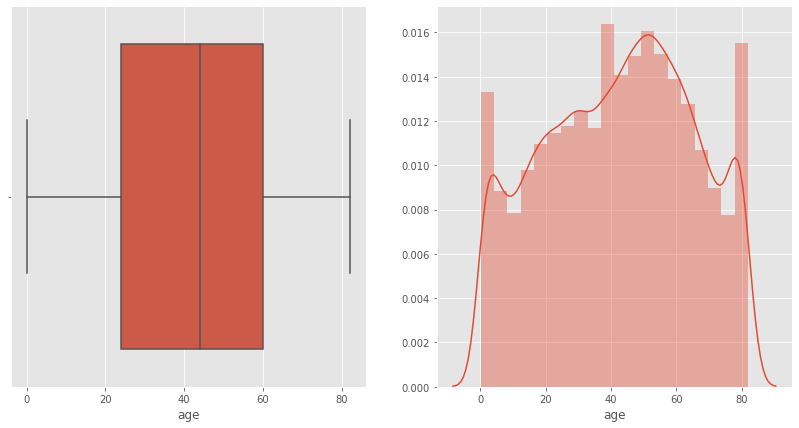

In [7]:
#---- Visualize numerical variable (age) ----#
EDA_plot_num_var(df_eda, 'age')

### Summary: Age, avg_glucose_level, bmi

Visualizes the numerical variables. First, the box plot shows that mean of age is somewhere around 45. Second, the histogram shows the distribution of age is a multi-modal skewed distribution (i.e., multiple peaks on a distribution curve).

In [8]:
#--- Use IQR to detect potential outliers ----#
stat = df_eda.avg_glucose_level.describe()
print(stat)
IQR = stat['75%'] - stat['25%'] 
UB = stat['75%'] + 1.5*IQR
LB = stat['25%'] - 1.5*IQR
print('The LB and UB for suspected avg. glucose outliers are {} and {}. '.format(LB, UB))

# Check LB Outliers:
df_eda[df_eda.avg_glucose_level < 25.745]

# Check UB Outliers:
df_eda[df_eda.avg_glucose_level > 163.8649]

# check potential outliers by categorical vars:
df_eda.loc[df_eda.avg_glucose_level > 163.8649, 'work_type'].value_counts()
df_eda.loc[df_eda.avg_glucose_level > 163.8649, 'smoking_status'].value_counts()

#--- Check the suspicious outliers by an economic typology: mining-dependent
df_eda[(df_eda.avg_glucose_level > 163.8649) & (df_eda.smoking_status == 'never smoked')]

count    43400.000000
mean       104.482750
std         43.111751
min         55.000000
25%         77.540000
50%         91.580000
75%        112.070000
max        291.050000
Name: avg_glucose_level, dtype: float64
The LB and UB for suspected avg. glucose outliers are 25.745000000000026 and 163.86499999999998. 


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
13,Female,33.0,No,No,Yes,Govt_job,Rural,194.06,40.8,never smoked,0
34,Female,13.0,No,No,No,Private,Rural,195.10,27.6,never smoked,0
38,Male,78.0,No,Yes,Yes,Self-employed,Urban,220.51,31.0,never smoked,0
44,Female,44.0,No,No,Yes,Private,Urban,204.11,23.5,never smoked,0
75,Female,18.0,No,No,No,Private,Urban,172.47,20.2,never smoked,0
77,Female,42.0,Yes,No,Yes,Private,Urban,204.10,43.1,never smoked,0
79,Male,54.0,No,Yes,Yes,Govt_job,Urban,222.46,35.7,never smoked,0
86,Female,65.0,No,No,Yes,Self-employed,Rural,207.12,27.7,never smoked,0
113,Male,69.0,No,No,Yes,Self-employed,Urban,218.98,31.8,never smoked,0
117,Male,57.0,No,No,Yes,Private,Rural,201.22,64.1,never smoked,0


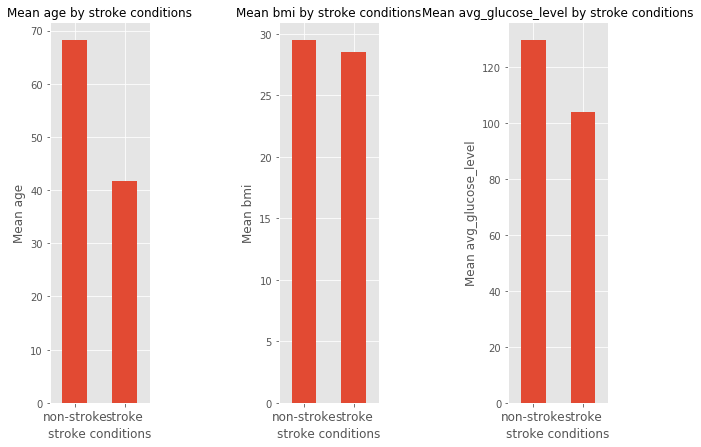

In [9]:
#############################
#---- Plot bar chart(s) ----#
#############################
# split dataframe by label:
df_stroke, df_non_stroke = split_data_by_label(df_eda, 'stroke')

# Create a list of label:
lab_list = list(df_eda['stroke'].unique())                 
lab_name = ['non-stroke', 'stroke']

# mean numeric variables by stroke conditions:    
EDA_plot_mean_label_barchart(df_eda, 'age', 'bmi', 'avg_glucose_level', 
                             'stroke', lab_list, lab_name)

### Summary of Mean Bar Chart(s): by Different Patient Groups ###

1. Mean Age: Mean age of stroke patient group is much lower (i.e., 43) than non-stroke group.
2. Mean BMI: Mean bmi of stroke patient group is slightly lower (i.e., 27) than non-stroke group.
3. Mean Avg. Glucose Level: Mean avg. glucose level of stroke patient group is lower (i.e., 105) than non-stroke group.

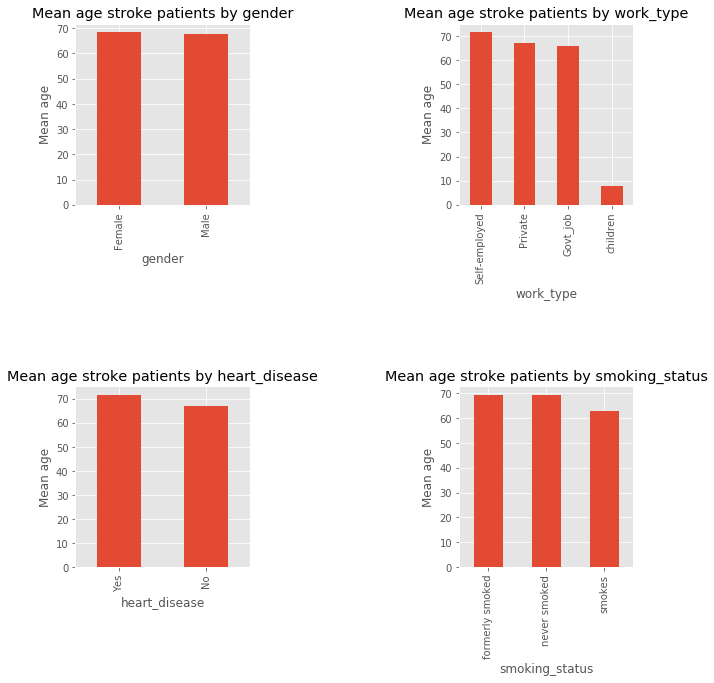

In [10]:
# mean age of stroke patients by categorical factors:    
EDA_plot_mean_cat_barchart(df_stroke, 'age', 'gender', 'work_type', 'heart_disease', 'smoking_status')

### Summary of Mean Bar Chart(s): by Categorical Variables ###

1. Gender: mean age of stroke patients for male and female were quite similiar (i.e., age = 67).
2. Work Type: mean age of stroke patients with a self-employed is the oldest (i.e., 71) in comparison to childrent related occupation group (i.e., below 10).
3. Heart Disease: mean age of stroke patients with no history of heart disease is a bit lower (i.e., age = 67).
4. Smoking Status: mean age of stroke patients with regular smoking behavior is the youngest (i.e., age = 62).

C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:167: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


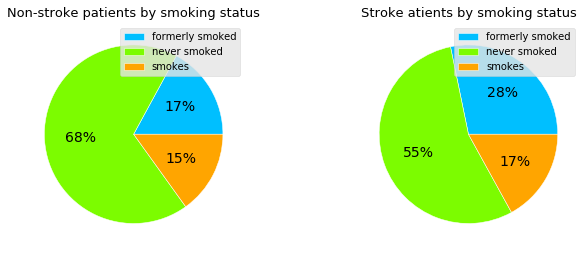

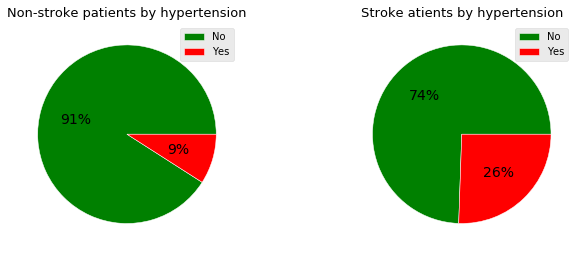

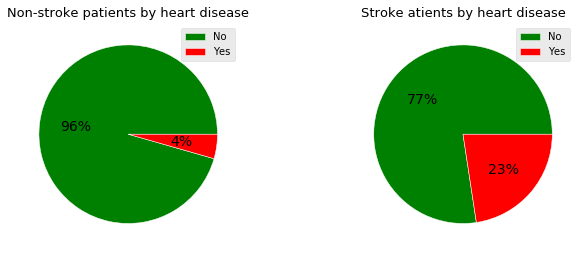

In [11]:
###########################
#---- Plot pie charts ----#
###########################
# Split a groupby dataframe by stroke label: smoking_status
df_grp_smoking_0, df_grp_smoking_1 = split_groupby_data(df_eda,'stroke','smoking_status')
# Split a groupby dataframe by stroke label: hypertension
df_grp_hypertension_0, df_grp_hypertension_1 = split_groupby_data(df_eda,'stroke','hypertension')
# Split a groupby dataframe by stroke label: heart_disease
df_grp_heart_disease_0, df_grp_heart_disease_1 = split_groupby_data(df_eda,'stroke','heart_disease')

# Plot a set of pie charts: by smoking_status
plot_pie_charts(df_grp_smoking_0, df_grp_smoking_1, df_grp_smoking_0.index,
                'smoking status', ['deepskyblue','lawngreen','orange'])
# Plot a set of pie charts: by hypertension
plot_pie_charts(df_grp_hypertension_0, df_grp_hypertension_1, df_grp_hypertension_0.index,
                'hypertension', ['green', 'red'])
# Plot a set of pie charts: by heart_disease
plot_pie_charts(df_grp_heart_disease_0, df_grp_heart_disease_1, df_grp_heart_disease_0.index,
                'heart disease', ['green', 'red'])

### Summary of Pie Chart Group 1: ###
In comparison to stroke patient group vs. non-stroke patient group

1. **Smoking Status:** stroke patient(s) are tend to be a regular smoker than non-stroke patient(s).
2. **Hypetension:** stroke patient(s) are more likely to be at risk of high blood pressure than non-stroke patient(s).
3. **Heart Disease:** stroke patient(s) are more likely to have history of heart disease(s) than non-stroke patient(s).

C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:167: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


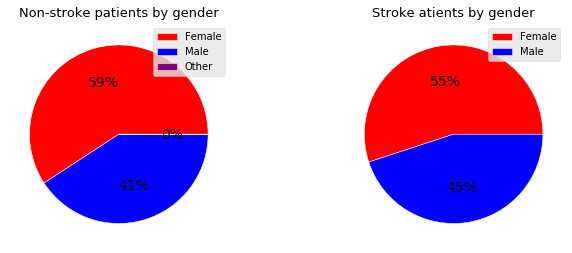

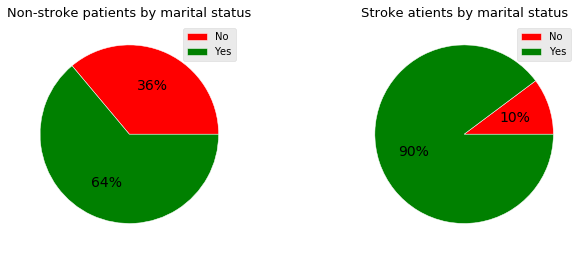

In [12]:
# Split a groupby dataframe by stroke label: gender
df_grp_gender_0, df_grp_gender_1 = split_groupby_data(df_eda,'stroke','gender')
# Split a groupby dataframe by stroke label: marital_status
df_grp_marital_0, df_grp_marital_1 = split_groupby_data(df_eda,'stroke','ever_married')

# Plot a set of pie charts: by gender
plot_pie_charts(df_grp_gender_0, df_grp_gender_1, df_grp_gender_0.index,
                'gender', ['red', 'blue', 'purple'])
# Plot a set of pie charts: by marital_status
plot_pie_charts(df_grp_marital_0, df_grp_marital_1, df_grp_marital_0.index,
                'marital status', ['red', 'green'])


### Summary of Pie Chart Group 2: ###
In comparison to stroke patient group vs. non-stroke patient group

1. **Gender:** from both patient groups, there are more female patients than male patients (i.e., by 10-14%).
2. **Marital Status:** stroke patient(s) are more likely to be married than non-stroke patient(s).

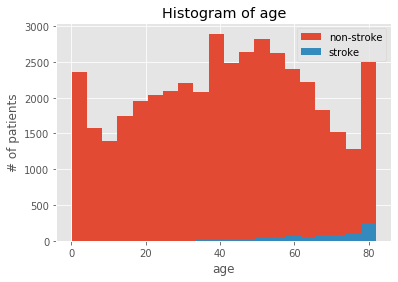

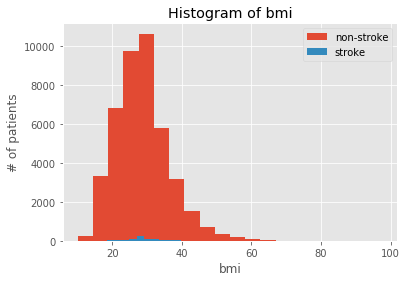

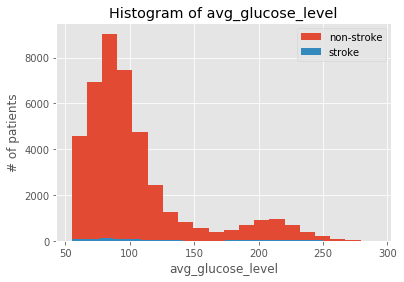

In [13]:
#############################
#---- Plot histograms ----# #
#############################
# Plot multiple histograms on numerical variables by a stroke label:
EDA_plot_hist_label(df_eda, 'age', 'stroke', 20, lab_list)
plt.legend(('non-stroke','stroke'), loc='upper right')
plt.show()

EDA_plot_hist_label(df_eda, 'bmi', 'stroke', 20, lab_list)
plt.legend(('non-stroke','stroke'), loc='upper right')
plt.show()

EDA_plot_hist_label(df_eda, 'avg_glucose_level', 'stroke', 20, lab_list)
plt.legend(('non-stroke','stroke'), loc='upper right')
plt.show()

### Summary: Histogram(s) by Different Patient Groups ###
1. **Age:** Distribution of age on stroke population indicated that majority of patients were senior (i.e., skewed to left).
2. **BMI:** A uniform distribution on both populations. Most of stroke patients were in BMI range between from 25 to 27.
3. **Avg_glucose_level:** a histogram showed non-uniform distribution on both populations. Most of non-stroke population were non-diabetic as shown above figure. On the other hand, distribution of mean glucose on stroke population showed bi-modal peaks.

Skewness is:Avg. Glucose Level 1.6754049014377774
Skewness is:Body Mass Index 0.9255483805080528
Skewness is:Age -0.10249737146133678


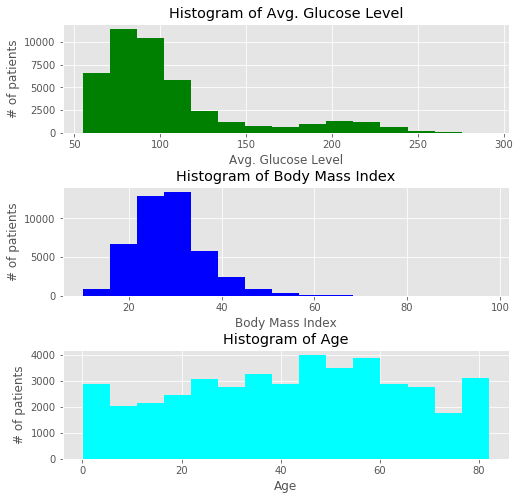

In [14]:
# Plot 3by1 histogram as a subplot: numerical variables
EDA_plot_hist_3by1(df_eda,
                   'avg_glucose_level', 15, 'Avg. Glucose Level',
                   'bmi', 15, 'Body Mass Index',
                   'age', 15, 'Age', 1)
plt.show()

### Summary: Histogram(s) by Numerical Variables ###
In general, both bmi and avg. glucose level variables are highly skewed to right (i.e., positive direction).
Wherease the distrubtion of age is a bit more closer to normal distrubtion but skewed to left (i.e., negative direction).

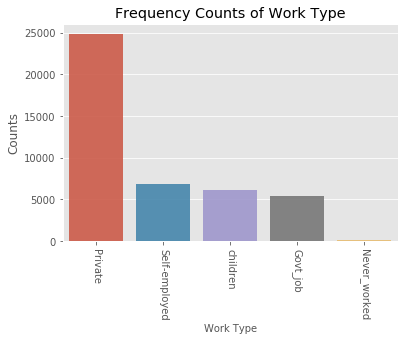

In [15]:
##############################
#---- Plot frequency chart(s) ----##
##############################
# Plot frequency chart: work_type
EDA_plot_freq_chart(df_eda, 'work_type', 'Work Type')
plt.show()

### Summary: Frequency Count Plot(s) ###
For entire patient population, the highest proportion of patients have a private occupation. 

In contrast, the lowest proportion of patients actually never worked at all.

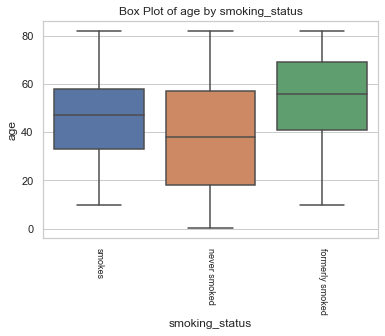

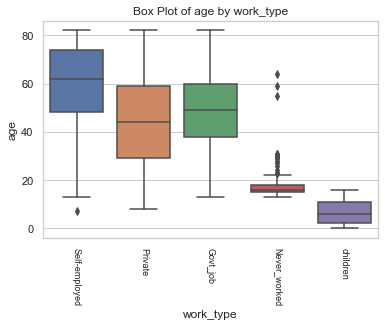

In [16]:
##########################################
#---- Plot box-whisker plot chart(s) ----#
##########################################
# Plot box plot: Smoking Status
EDA_plot_box_whisker(df_eda, 'age', 'smoking_status')
plt.show()
# Plot box plot: Work Type
EDA_plot_box_whisker(df_eda, 'age', 'work_type')
plt.show()

### Summary: Box-Whisker Plot ###

* Smoking Status: formerly smoked group has the highest mean age. Conversely, never smoked group has the lowest mean age.
* Work Type: Self-employed group has the highest mean age. In contrast, children group has the lowest mean age.

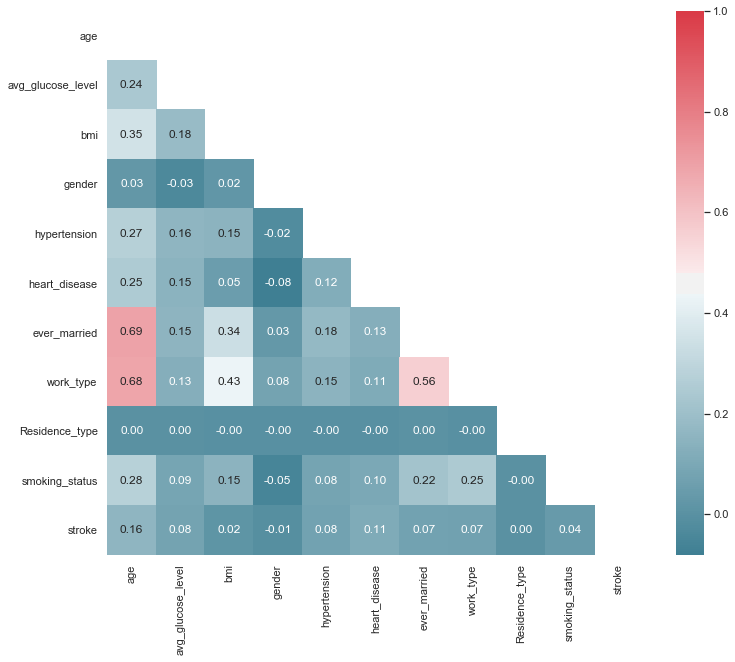

In [17]:
#---- Convert categorical variable data type from object to category ----#
df_eda_cm = df_eda.copy() 
EDA_convert_object_to_cat(df_eda_cm)

#---- Encode categorical variables using avg. numerical variable for each category to replace label ----#
for col in df_eda_cm.columns:
    if df_eda_cm[col].dtype.name == "category":
        EDA_encode_cat_var(df_eda_cm, col, 'age')
        
#---- Plot correlation matrix chart ----#
# Define list of features and salary
features = ['age', 'avg_glucose_level', 'bmi', 'gender',
            'hypertension', 'heart_disease',  'ever_married', 
            'work_type', 'Residence_type',  'smoking_status']
label = ['stroke']

# Plot a correlation matrix:
EDA_plot_corr_matrix(df_eda_cm, features, label)

### Summary: Correlation Matrix Plot ###
We can see from above matrix that, age is the highest correlated variable against the stroke label (i.e., r=0.16). Followed by presence of heart disease, avg. glucose level and etc.

There are a few interesting feature-to-feature interaction(s):
1. Age shows a strong positive correlation with a marital status (i.e., r=0.69).
2. Age shows a strong positive correlation with a work type (i.e., r=0.68).
3. BMI shows a moderate positive correlation with a work type (i.e., r=0.43).

In [18]:
###################################
#---- Plot a cross-tabulation ----#    
###################################
EDA_plot_crosstab(df_eda, 'heart_disease', 'hypertension')

hypertension,No,Yes
heart_disease,,
No,37792,3546
Yes,1547,515


In [19]:
EDA_plot_crosstab(df_eda, 'work_type', 'Residence_type')

Residence_type,Rural,Urban
work_type,,
Govt_job,2714,2726
Never_worked,84,93
Private,12320,12514
Self-employed,3444,3349
children,3082,3074


### Summary: Cross-Tablulation ###
1. Cross-Tab of Hypertension & Heart Disease: shows that a very small portion of patient population have both history of hypertension and heart disease together. Majority of patients are in a group with no history of complications.

2. Cross-Tab of Residence Type & Work Type: shows that there are no significant trend(s) observed since both population reside in rural and urban have almost equal propotion of patient(s) occupying different job types. 

0.06305985206922853
0.23266307160472002
-0.23494377086982232
0.35670855855606104


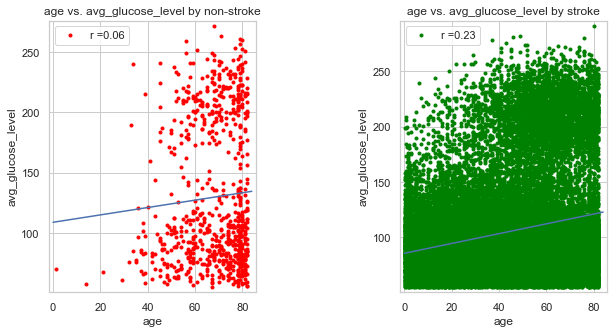

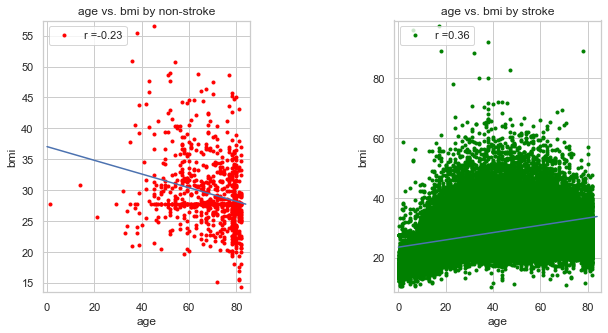

In [20]:
######################################
#---- Linear Regression Analysis ----#
######################################
# Compute correlation coefficient:
# Compute Pearson r for stroke: age vs. glucose
r_age_glucose_1 = Pearson_r(df_stroke, 'age', 'avg_glucose_level')
print(r_age_glucose_1) 
# Compute Pearson r for non-stroke: age vs. glucose
r_age_glucose_0 = Pearson_r(df_non_stroke, 'age', 'avg_glucose_level')
print(r_age_glucose_0)     

# Compute Pearson r for stroke: age vs. bmi
r_age_bmi_1 = Pearson_r(df_stroke, 'age', 'bmi')
print(r_age_bmi_1) 
# Compute Pearson r for non-stroke: age vs. bmi
r_age_bmi_0 = Pearson_r(df_non_stroke, 'age', 'bmi')
print(r_age_bmi_0)     

# Plot regression fit a pair of plots by stroke condition(s):
EDA_plot_pair_linreg(df_non_stroke, df_stroke, 'age', 'avg_glucose_level',
                     r_age_glucose_0, r_age_glucose_1, 'stroke', 'non-stroke')
plt.show()

# Plot regression fit a pair of plots by stroke condition(s):
EDA_plot_pair_linreg(df_non_stroke, df_stroke, 'age', 'bmi',
                     r_age_bmi_0, r_age_bmi_1, 'stroke', 'non-stroke')
plt.show()

### Summary: Linear Regression Analyses by Different Patient Group(s) ###

**Age vs. Avg. Glucose Level**: a scatter plot for stroke patient group shows very weak correlation (r-value of 0.07) between age and average glucose level. As stroke patients get older, there is a slight increase in average glucose levels. Conversely, non-stroke patient population showed a bit stronger correlation with a r-value of 0.23.

**Age vs. BMI**: a scatter plot for stroke patient group shows moderate correlation (r-value of 0.36) between age and body mass index (BMI). As stroke patients get older, there is a  increase in BMI observed. Conversely, non-stroke patient population showed an exact opposite trend where a negative correlation with a r-value of -0.23.

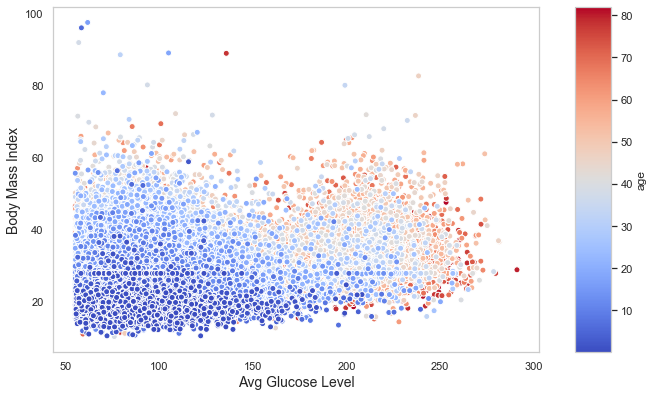

In [21]:
#################################################################
#---- Plot color scaled scatter plots by numerical variable ----#
#################################################################
EDA_plot_color_sc_scatter(df_eda, 'avg_glucose_level','Avg Glucose Level',
                          'bmi', 'Body Mass Index', 'age')
plt.show()

### Summary: Color Bar Scatter Plot ###

Above scatter plot shows the changes in age distribution with respect to a relationship between avg. glucose level and body mass index (BMI). The plot shows that with increase in level of avg. glucose and BMI, patients are more older than the exact opposite cases (i.e., low glucose level and low BMI).